# Investigation of High Volumes in MTO 400-series Highway Data

In [1]:
%matplotlib inline
%load_ext autoreload
from utilities import db_connect
from utilities import get_sql_results
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
db = db_connect()
sql = 'SELECT hwy_name, loc_desc, width_bucket(volume/num_lanes*2, 0, 3600, 35) AS buckets, COUNT(*) \
        FROM mto.sensors JOIN mto.mto_agg_30 USING (detector_id) \
        WHERE detector_id = $1 AND EXTRACT(HOUR FROM count_bin) = $2 AND flag IS NULL\
        GROUP BY detector_id, hwy_name, loc_desc, buckets \
        ORDER BY detector_id, hwy_name, loc_desc, buckets'

In [3]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.1f' % (height),
                ha='center', va='bottom')
        
def barplot(ax, data, color, hour):
    rect = ax.bar(data['lower'], data['count'], width = 100, color = color)
    autolabel(ax, rect)
    if  data['loc_desc'][0].find(data['hwy_name'][0]) >= 0:
        ax.set_title(data['loc_desc'][0] + ' at Hour ' + str(hour))
    else:
        ax.set_title(data['hwy_name'][0] + ' '+ data['loc_desc'][0] + ' at Hour ' + str(hour))
    ax.set_xlim([0,3500])
    
def plot_data(detector_ids, hours):
    fig,axes = plt.subplots(2, 2, figsize=(18,9), sharey=True)

    i = 0
    for h in hours:
        for d in detector_ids:
            data = get_sql_results(db, sql, columns=['hwy_name', 'loc_desc', 'buckets','count'], parameters = [d, h])
            total = data['count'].sum()
            data['count'] = data['count']/total*100
            data['lower'] = (data['buckets']-1)*100
            data['upper'] = data['buckets'] * 100
            if i == 0:
                barplot(axes[int(i/2),i%2], data, 'red', h)
            else:
                barplot(axes[int(i/2),i%2], data, 'blue', h)
            axes[int(i/2),i%2].set_xlabel('Volume/lane/hour')
            axes[int(i/2),i%2].set_ylabel('% Records')
            i = i + 1

### Plots Explained
**Plots in the same column are from the same segment progressing in time.
Plots in the same row are from the same hour, adjacent segments. Plot highlighted in red is the one with abnormorlly high volumes.**

**'X' marks the location where 95% percentile volume exceeds 2000. 
Red dot marks the location upstream for comparison.**

### 401 Westbound between Bayview and Leslie
![401_Leslie_Bayview.png](img/401_Leslie_Bayview.png)


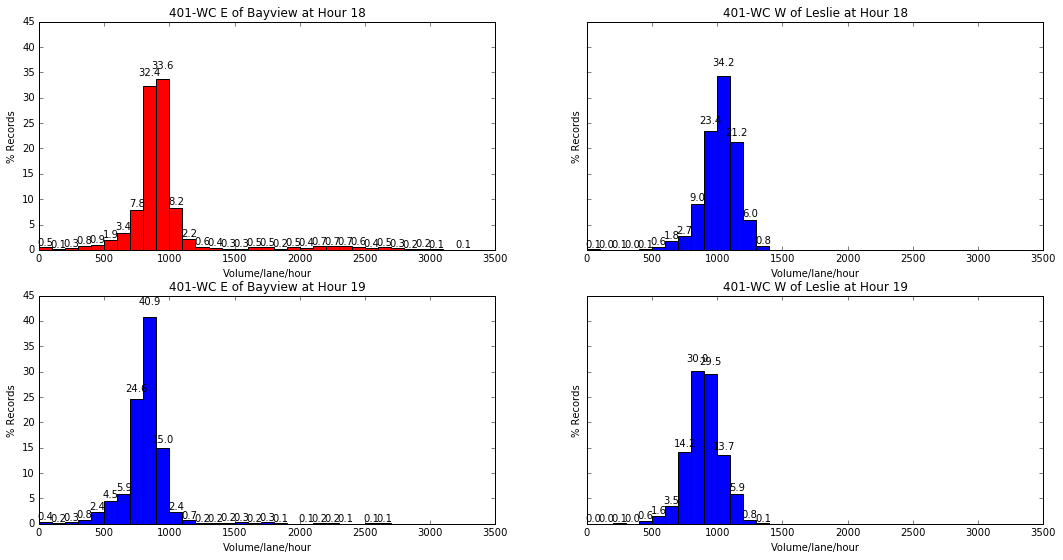

In [4]:
detector_ids = ['401DE0170DWC', '401DE0180DWC']
hours = [18, 19]
plot_data(detector_ids, hours)

In this case, the comparison segment is upstream of the target segment. Between the segments there is an off-ramp and no on-ramps, meaning that the upstream segments should always have bigger volume than the target segment.

1. The segment upstream does not have any volume bigger than 1500 per hour per lane, despite the volume being higher.
2. Graphically, the high counts are extreme outliers. 

Therefore, the high counts must come from faulty detectors.

### 404 NB between Finch and McNicoll
![404_Finch_McNicoll.png](img/404_Finch_McNicoll.png)

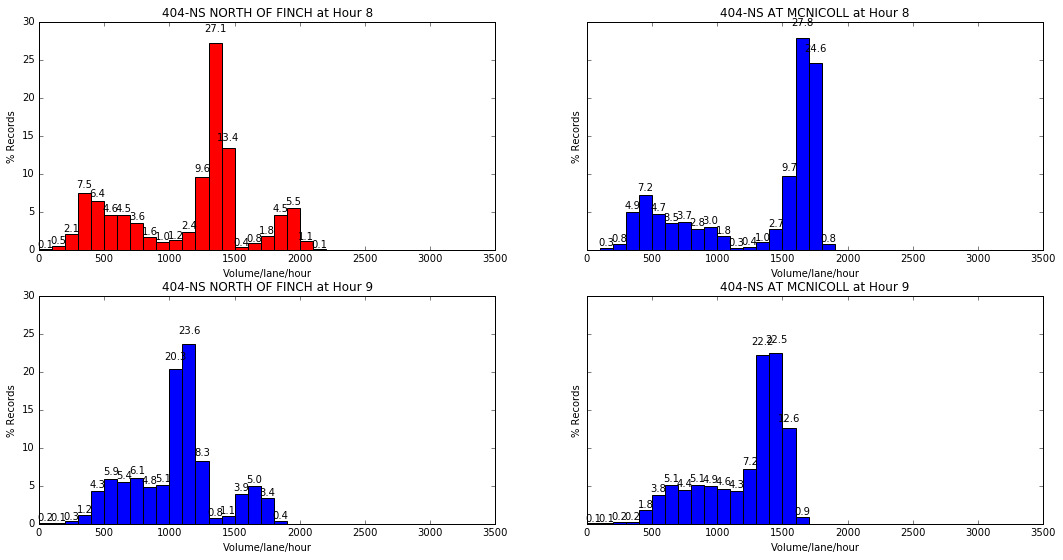

In [5]:
detector_ids = ['404DN0030DNS', '404DN0040DNS']
hours = [8, 9]
plot_data(detector_ids, hours)

The downstream segment volume equals upstream volume + the on-ramp. Therefore, the downstream segment should alway have higher volume, which is generally the case here. However, the peak at around 1900-2000 veh/lane/hour at the target location is not in line with the downstream situation.

### 401 @ Renforth
![401_Renforth.png](img/401_Renforth.png)

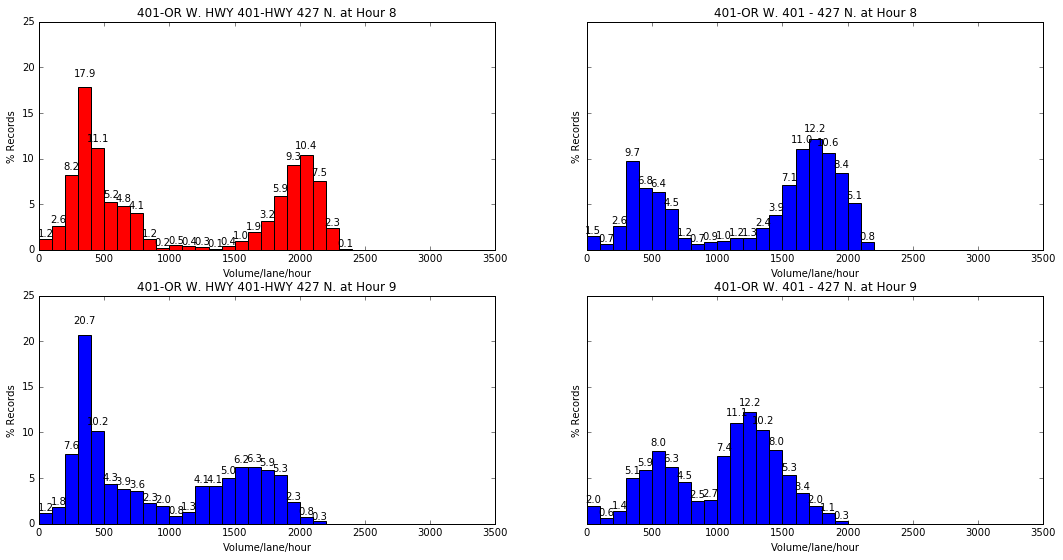

In [7]:
detector_ids = ['401DW0430DNR', '401DW0070DNR']
hours = [8, 9]
pct_95 = [2242, 2090, 1943, 1736]
plot_data(detector_ids, hours)

The two detectors should be detecting the same volume. But they are not. the one upstream is consistently detecting more volume than the one downstream. But the distributions don't seem to have heavy outliers.

## Final Remarks
Most of the malfunctions occurs on ramps and during peak hours.

In [87]:
db.close()